In [1]:
import numpy as np
import matplotlib.pyplot as plt

import keras

from sklearn.metrics import classification_report
from sklearn.manifold import TSNE

import medmnist
from medmnist import INFO

import sys
sys.path.insert(0,"../../")

import dataset_without_pytorch

from functions import split_data, get_label_counts, generate_testing_mixup_images, find_boundary_points
from plotting_functions import plot_3_confusion_matricies, plot_calibration, muba_curves
import pandas as pd

from functions import argmax_array

In [2]:
data_flag = 'pneumoniamnist'

download = True

image_size = 128

info = INFO[data_flag]

DataClass = getattr(dataset_without_pytorch, info['python_class'])

In [3]:
# load the data
train_dataset = DataClass(split='train', download=download, size = image_size)
test_dataset = DataClass(split='test', download=download, size = image_size)
val_dataset = DataClass(split='val', download=download, size = image_size)

Using downloaded and verified file: C:\Users\Will Poulett\.medmnist\pneumoniamnist_128.npz
Using downloaded and verified file: C:\Users\Will Poulett\.medmnist\pneumoniamnist_128.npz
Using downloaded and verified file: C:\Users\Will Poulett\.medmnist\pneumoniamnist_128.npz


In [4]:
RANDOM_SEED = 1

X_train, y_train, X_val, y_val, X_test_A, y_test_A, X_test_B, y_test_B = split_data(
  train_dataset, test_dataset, val_dataset, RANDOM_SEED = RANDOM_SEED, one_hot_encoded = True, num_classes=2, image_size = 128)


In [5]:
# As a sanity check to make sure we have the correct test data, check counts

get_label_counts(y_train,y_val,y_test_A,y_test_B,class_names = ["Normal","Pneumonia"])


Train
{(0, 1): 3494, (1, 0): 1214}  ['Normal', 'Pneumonia']

Val
{(0, 1): 389, (1, 0): 135}  ['Normal', 'Pneumonia']

Test A
{(0, 1): 117, (1, 0): 70}  ['Normal', 'Pneumonia']

Test B
{(0, 1): 273, (1, 0): 164}  ['Normal', 'Pneumonia']


In [6]:
test_set_A_df = pd.DataFrame({
    "image_index":[i for i in range(len(y_test_A))],
    "class":[label[1] for label in y_test_A]}) # 0 if normal, 1 if pneumonia

In [7]:
MUBA_ITERS = 20

muba_df = generate_testing_mixup_images(test_set_A_df, X_test_A, MUBA_ITERS)

In [8]:
# To allow for reproducability, we add our alpha values
alpha_values = muba_df["alpha_class_0"]
alpha_values.to_csv("alpha_values.csv")

In [9]:
model = keras.models.load_model("best_model_epoch_26.h5")
activations_model = keras.Model(model.input,model.layers[-2].output)

In [10]:
predictions_A = model.predict(X_test_A)
activations_A = activations_model.predict(X_test_A)

predictions_B = model.predict(X_test_B)
activations_B = activations_model.predict(X_test_B)

print("Stacking - this can take some time.")
stacked_images = np.stack(muba_df["image"])
predictions_mixup = model.predict(stacked_images)
activations_mixup = activations_model.predict(stacked_images)

14/14 [==============================] - 1s 61ms/step
Stacking - this can take some time.
5119/5119 [==============================] - 341s 67ms/step


In [11]:
predictions_A_ft = [0 if a[0] > 0.2 else 1 for a in predictions_A]
predictions_B_ft = [0 if a[0] > 0.2 else 1 for a in predictions_B]
predictions_mixup_ft = [0 if a[0] > 0.2 else 1 for a in predictions_mixup]

In [12]:
print("Test Set A")
print(classification_report(argmax_array(y_test_A), predictions_A_ft, target_names = ['Normal (Class 0)','Pneumonia (Class 1)']))
print("\nTest Set B")
print(classification_report(argmax_array(y_test_B),predictions_B_ft, target_names = ['Normal (Class 0)','Pneumonia (Class 1)']))

Test Set A
                     precision    recall  f1-score   support

   Normal (Class 0)       0.91      0.96      0.93        70
Pneumonia (Class 1)       0.97      0.94      0.96       117

           accuracy                           0.95       187
          macro avg       0.94      0.95      0.94       187
       weighted avg       0.95      0.95      0.95       187


Test Set B
                     precision    recall  f1-score   support

   Normal (Class 0)       0.94      0.92      0.93       164
Pneumonia (Class 1)       0.95      0.97      0.96       273

           accuracy                           0.95       437
          macro avg       0.95      0.94      0.95       437
       weighted avg       0.95      0.95      0.95       437



In [14]:
print("Test Set A")
print(classification_report(argmax_array(y_test_A), argmax_array(predictions_A), target_names = ['Normal (Class 0)','Pneumonia (Class 1)']))
print("\nTest Set B")
print(classification_report(argmax_array(y_test_B),argmax_array(predictions_B), target_names = ['Normal (Class 0)','Pneumonia (Class 1)']))

Test Set A
                     precision    recall  f1-score   support

   Normal (Class 0)       0.97      0.87      0.92        70
Pneumonia (Class 1)       0.93      0.98      0.95       117

           accuracy                           0.94       187
          macro avg       0.95      0.93      0.94       187
       weighted avg       0.94      0.94      0.94       187


Test Set B
                     precision    recall  f1-score   support

   Normal (Class 0)       0.97      0.85      0.91       164
Pneumonia (Class 1)       0.92      0.99      0.95       273

           accuracy                           0.94       437
          macro avg       0.95      0.92      0.93       437
       weighted avg       0.94      0.94      0.93       437



In [13]:
muba_df["predictions_0"] = [p[0] for p in predictions_mixup]
muba_df["predictions_1"] = [p[1] for p in predictions_mixup]
muba_df["argmax_pred"] = [np.argmax(p) for p in predictions_mixup]
muba_df["argmax_pred_ft"] = predictions_mixup_ft
muba_df["activations"] = [a for a in activations_mixup]

In [15]:
muba_df.head()

,alpha_class_0,alpha_class_1,class_0_index,class_1_index,image,type,label,predictions_0,predictions_1,argmax_pred,argmax_pred_ft,activations
0,0.002961,0.997039,0,1,"[[[111.94670559345819], [106.96150959527536], ...",mix,1,8.390959e-16,1.0,1,1,"[0.0, 0.0, 6.589875, 0.0, 0.0, 0.0, 15.39139, ..."
1,0.091053,0.908947,0,1,"[[[110.36103767840898], [105.81630498996203], ...",mix,1,2.033469e-16,1.0,1,1,"[0.0, 0.0, 9.433466, 0.0, 0.0, 0.0, 18.140938,..."
2,0.137884,0.862116,0,1,"[[[109.51809267804056], [105.20751137858484], ...",mix,1,4.390043e-16,1.0,1,1,"[0.0, 0.0, 9.611535, 0.0, 0.0, 0.0, 17.628498,..."
3,0.170673,0.829327,0,1,"[[[108.92787968922836], [104.78124644222049], ...",mix,1,1.504176e-15,1.0,1,1,"[0.0, 0.0, 9.372245, 0.0, 0.0, 0.0, 16.603174,..."
4,0.204346,0.795654,0,1,"[[[108.32176477577374], [104.34349678250325], ...",mix,1,1.113409e-14,1.0,1,1,"[0.0, 0.0, 8.649938, 0.0, 0.0, 0.0, 15.137519,..."


In [16]:
incorrect_ft = muba_df[muba_df["argmax_pred_ft"]!=muba_df["label"]]
incorrect = muba_df[muba_df["argmax_pred"]!=muba_df["label"]]

(array([ 460.,  427.,  370.,  323.,  291.,  261.,  276.,  361.,  563.,
         933., 6572., 5557., 4384., 3320., 2423., 1791., 1367.,  960.,
         766.,  583.]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]),
 <BarContainer object of 20 artists>)

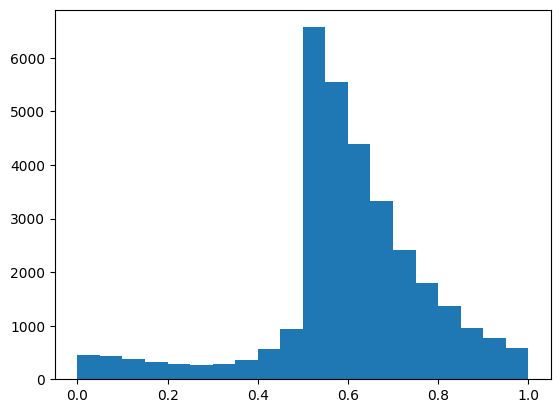

In [17]:
plt.hist(incorrect_ft["alpha_class_0"],[i/20 for i in range(21)])

(array([ 138.,  102.,   65.,   39.,   36.,   39.,   56.,   99.,  173.,
         372., 7475., 6890., 6084., 5161., 4304., 3467., 2773., 2280.,
        1727., 1201.]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]),
 <BarContainer object of 20 artists>)

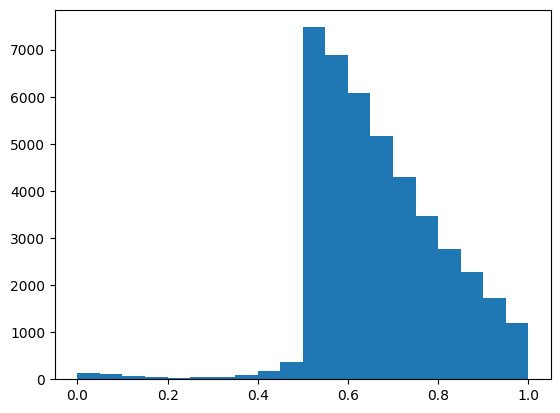

In [18]:
plt.hist(incorrect["alpha_class_0"],[i/20 for i in range(21)])